# Sentiment Analysis and topic Modeling

### This part includes the analysis of sentiment and topics on the Twitter data about GameStop between 2020-12-27 and 2021-02-26.

In [2]:
!pip install emoji
!pip install gif

     |████████████████████████████████| 133kB 4.0MB/s 
  Created wheel for gif: filename=gif-3.0.0-cp37-none-any.whl size=4817 sha256=4e1dd01868a91fb6b98c69c30f2f7e7f7b9514f685feb6b1d25743af5a5b8680
  Stored in directory: /root/.cache/pip/wheels/33/1a/03/e7ccc13d5cbed82b0fda53a7792dfe372cf8baf691601d78d1
Successfully built gif


In [3]:
# libraries
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import emoji
import plotly.graph_objects as go
import gif
import plotly.offline as pyo
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# data
df = pd.read_csv('gamestop_twitter.csv')

# check duplicates
df = df.drop_duplicates()

In [5]:
# Df clean up
my_stopwords = nltk.corpus.stopwords.words('english') + \
               ['like','would','see','la','de', 'que',"'s", "’s"]
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@’'

def clean_up(text):
    text = text.lower()
    # remove replied msg
    if 'rt @' in text:
        if len(text.split(": ")) < 2:
            text = text.split(": ")[0]
        else:
            text = text.split(": ")[1]
    # remove the unnecessay URLs
    if "https" in text:
        text = text.split("https")[0]
    if "@" in text:
        text = text.split(" ")
        # remove the strings with symbol @
        text = [j for j in text if '@' not in j]
        text = ' '.join(text)
    # remove hashtag symbols
    text = text.replace("#", "")
    text = text.replace("'s'", "")
    text = text.replace("’s'", "")
    text = re.sub('['+my_punctuation + ']+', ' ', text)# strip punctuation
    text = re.sub('\s+', ' ', text)#remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text = emoji.get_emoji_regexp().sub(u'', text) # remove emoji
    text = ' '.join([word for word in text.split(' ') if word not in my_stopwords]) # remove stopwords
    return text

In [6]:
df['clean_tweet'] = df['Text'].map(clean_up)

In [12]:
# Topic modeling

vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

tf_feature_names = vectorizer.get_feature_names()

number_of_topics = 5

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=101)

model.fit(tf)

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 5
topcis = display_topics(model, tf_feature_names, no_top_words)
topcis

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words
0,gme,ps,stock,en,hedge
1,amc,gt,gme,el,die
2,wallstreetbets,gme,market,reddit,people
3,gamestonk,link,reddit,street,und
4,robinhood,di,robinhood,wall,der


In [13]:
# download the file for better visualization
topcis.to_csv('topics_result.csv',index=False)

In [8]:
# Topic modeling for each date



df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()
df['Date'] = df['Datetime'].dt.date 

dates = df.Date.unique()
topics_dates = pd.DataFrame()

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

for i in dates:
    vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

    tf = vectorizer.fit_transform(df[df['Date']==i]['clean_tweet']).toarray()
    
    tf_feature_names = vectorizer.get_feature_names()
    
    number_of_topics2 = 1
    no_top_words2 = 1
    
    model2 = LatentDirichletAllocation(n_components=number_of_topics2, random_state=101)
    
    model2.fit(tf)
    
    
    topics2 = display_topics(model2, tf_feature_names, no_top_words2)
    topics2['Date']=i
    
    topics_dates = topics_dates.append(topics2)
    
topics_dates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118423 entries, 0 to 118422
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Unnamed: 0      118423 non-null  int64              
 1   Datetime        118423 non-null  datetime64[ns, UTC]
 2   Tweet Id        118423 non-null  int64              
 3   Text            118423 non-null  object             
 4   Username        118423 non-null  object             
 5   user_mention    32816 non-null   object             
 6   followersCount  118423 non-null  int64              
 7   listedCount     118423 non-null  int64              
 8   clean_tweet     118423 non-null  object             
 9   Date            118423 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 9.9+ MB


,Topic 0 words,Date
0,gamestop,2021-02-26
0,gme,2021-02-25
0,gme,2021-02-24
0,gamestop,2021-02-23
0,gamestop,2021-02-22
...,...,...
0,shop,2020-12-31
0,shop,2020-12-30
0,shop,2020-12-29
0,shop,2020-12-28


In [93]:
topics_dates.to_csv("Topic_dates.csv",index=False)

In [16]:
# I save the data to avoid keeping the kernel stay connected.
topics_dates = pd.read_csv("Topic_dates.csv")

topics_dates = topics_dates.sort_values('Date')
topics_dates

,Topic 0 words,Date
0,shop,2020-12-27
1,shop,2020-12-28
2,shop,2020-12-29
3,shop,2020-12-30
4,shop,2020-12-31
...,...,...
57,gamestop,2021-02-22
58,gamestop,2021-02-23
59,gme,2021-02-24
60,gme,2021-02-25


In [96]:
topics_dates.groupby(['Topic 0 words']).count()

,Date
Topic 0 words,
gamestop,35
gme,14
gt,3
ps,1
shop,9


In [19]:
# before 01/27
topics_dates1 = topics_dates[topics_dates['Date']<'2021-01-27']
topics_dates1_topics = topics_dates1.groupby(['Topic 0 words']).count() 
# after 01/27
topics_dates2 = topics_dates[topics_dates['Date']>='2021-01-27']
topics_dates2_topics = topics_dates2.groupby(['Topic 0 words']).count() 

In [20]:
topics_dates1_topics

,Date
Topic 0 words,
gamestop,15
gme,3
gt,3
ps,1
shop,9


In [21]:
topics_dates2_topics

,Date
Topic 0 words,
gamestop,20
gme,11


# sentiment analysis by VADER


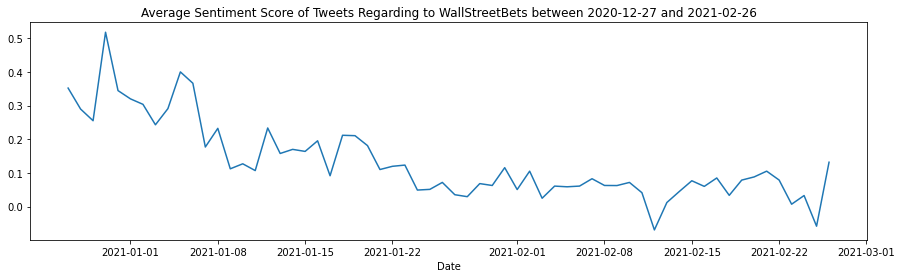

In [9]:
analyzer = SentimentIntensityAnalyzer()

VADER_score = []
for i in df['clean_tweet']:
    va = analyzer.polarity_scores(i)['compound']
    VADER_score += [va]

df['sentiment_score'] = VADER_score

# sentiment analysis for each date

sa_date = df.groupby('Date')['sentiment_score'].mean()
sa_date.plot(figsize=(15, 4), title="Average Sentiment Score of Tweets Regarding to WallStreetBets between 2020-12-27 and 2021-02-26")
sa_date = sa_date.to_frame().reset_index()

In [16]:
# download the file for better visualization
sa_date.to_csv('Sentiment_analysis.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



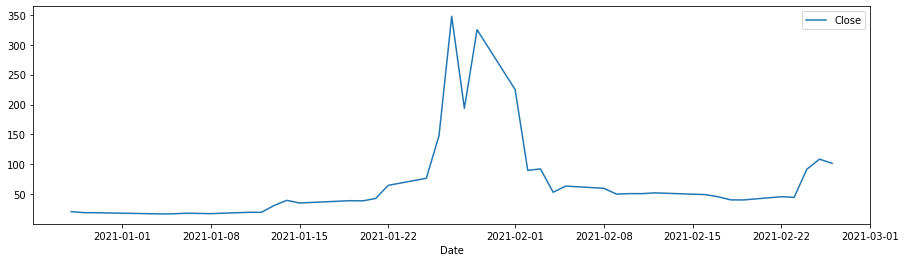

In [29]:
# stock data
from pandas_datareader import data
tickers = ['GME']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2020-12-27'
end_date = '2021-02-28'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('GME', 'yahoo', start_date, end_date).reset_index()


GME_stock = panel_data[['Date','Close']]
GME_stock['Date'] = GME_stock['Date'].dt.date
GME_stock.plot(x='Date',figsize=(15, 4))

In [28]:
print(GME_stock[['Date']])
# The GME stock data is not full because of we dont have stock info in the weekend

          Date
0   2020-12-28
1   2020-12-29
2   2020-12-30
3   2020-12-31
4   2021-01-04
5   2021-01-05
6   2021-01-06
7   2021-01-07
8   2021-01-08
9   2021-01-11
10  2021-01-12
11  2021-01-13
12  2021-01-14
13  2021-01-15
14  2021-01-19
15  2021-01-20
16  2021-01-21
17  2021-01-22
18  2021-01-25
19  2021-01-26
20  2021-01-27
21  2021-01-28
22  2021-01-29
23  2021-02-01
24  2021-02-02
25  2021-02-03
26  2021-02-04
27  2021-02-05
28  2021-02-08
29  2021-02-09
30  2021-02-10
31  2021-02-11
32  2021-02-12
33  2021-02-16
34  2021-02-17
35  2021-02-18
36  2021-02-19
37  2021-02-22
38  2021-02-23
39  2021-02-24
40  2021-02-25
41  2021-02-26


In [43]:
stock_sa = pd.merge(GME_stock, sa_date, on='Date')
stock_sa

,Date,Close,sentiment_score
0,2020-12-28,20.990000,0.289656
1,2020-12-29,19.379999,0.255024
2,2020-12-30,19.260000,0.517703
3,2020-12-31,18.840000,0.344452
4,2021-01-04,17.250000,0.290939
5,2021-01-05,17.370001,0.399937
6,2021-01-06,18.360001,0.366290
7,2021-01-07,18.080000,0.176947
8,2021-01-08,17.690001,0.232342
9,2021-01-11,19.940001,0.106474


In [66]:
stock_sa.to_csv("stock_sa.csv", index=False)

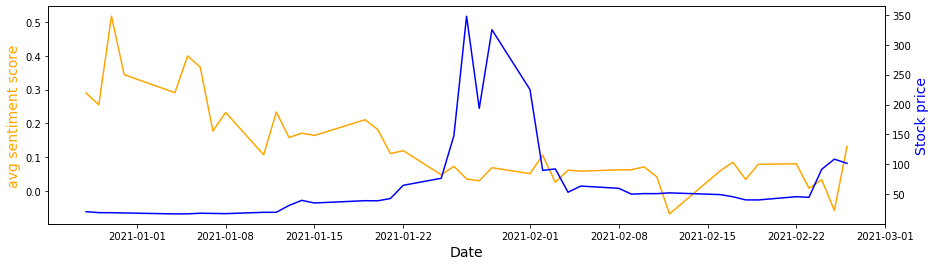

In [64]:
fig,ax = plt.subplots(figsize=(15, 4))
# make a plot
ax.plot(stock_sa.Date, stock_sa.sentiment_score, color="orange")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("avg sentiment score",color="orange",fontsize=14)


ax2=ax.twinx()
ax2.plot(stock_sa.Date, stock_sa.Close,color="blue")
ax2.set_ylabel("Stock price",color="blue",fontsize=14)
plt.show()
# save the plot as a file
#fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
 #           format='jpeg',
 #           dpi=100,
 #           bbox_inches='tight')
